# Finetuning the LLAMA 3.2 with Pure Pytorch

### LLAMA is a gated model and you will need to signin in using huggingface token to download the checkpoint (Only for the first time)

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

In [2]:
DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    device_map=device,
    torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)

In [3]:
print(model.get_memory_footprint()/(1024*1024)) 

2357.1290283203125


# How to ask a question to LLAMA 3.2

In [4]:
messages = [
    {"role": "user", "content": "What is the capital of Italy?"}
]

In [5]:
tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)
print(tokenized_text)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the capital of Italy?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [6]:
from transformers import pipeline

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generated_text = llama_pipeline(tokenized_text, max_new_tokens=20, early_stopping=True)

print(generated_text[0]['generated_text'])

Device set to use cuda
c:\Users\User\miniconda3\envs\torch_env\Lib\site-packages\transformers\generation\configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the capital of Italy?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The capital of Italy is Rome.


# What is behind the Pipeline function

In [7]:
inputs = tokenizer(tokenized_text, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
           2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
             25,    220,   1721,   3297,    220,   2366,     20,    271, 128009,
         128006,    882, 128007,    271,   3923,    374,    279,   6864,    315,
          15704,     30, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [8]:
# inputs = tokenizer(tokenized_text, return_tensors="pt",padding='max_length',max_length=300).to(device)
# tokenizer.pad_token_id = tokenizer.eos_token_id

In [9]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

In [10]:
logits.shape, inputs.input_ids.shape

(torch.Size([1, 43, 128256]), torch.Size([1, 43]))

In [11]:
predicted_ids = torch.argmax(logits, dim=-1)
print(predicted_ids)

next_word_id = predicted_ids[0, -1]
print(next_word_id)

tensor([[ 16309,  16309, 128006,    198,  78191,    567,   1303,    311,  22241,
             25,    220,    220,     16,     15,    198,   9673,    596,     25,
            510,   2360,   5936,    220,   2366,     18,    198,   2028, 128006,
          78191,   3638,    271,    644,    374,    279,   1888,    315,   1561,
           5380,  22463, 128006,  78191, 128007,    271,    791]],
       device='cuda:0')
tensor(791, device='cuda:0')


In [12]:
print('The predicted next word:')
tokenizer.decode(next_word_id)

The predicted next word:


'The'

In [13]:
new_input_ids = torch.cat([inputs.input_ids, next_word_id.view((-1,1))], dim=-1)

In [14]:
with torch.no_grad():
    outputs = model(new_input_ids)

logits = outputs.logits

predicted_ids = torch.argmax(logits, dim=-1)

next_word_id = predicted_ids[0, -1]

new_input_ids = torch.cat([new_input_ids, next_word_id.view((-1,1))], dim=-1)

print('The predicted next word:')
print(tokenizer.batch_decode(new_input_ids)[0])

The predicted next word:
<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the capital of Italy?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The capital


# What happens when we ask something out of it's training

In [15]:
# Q: What is BG-CNN and what does it do?
# A: BG-CNN is a hybrid FDI method that combines Bond Graph residual generation with CNN-based fault classification, designed to work well even with limited labeled data.

# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.

messages = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}
]

tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generated_text = llama_pipeline(tokenized_text, max_new_tokens=20, early_stopping=True)

print(generated_text[0]['generated_text'])

Device set to use cuda
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

How does BG-XAI help in fault diagnosis?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I don't have information on the BG-XAI system, as my knowledge cutoff is 01 March


# Let's train the model to learn this new sentence

In [48]:
messages = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"},
    {"role": "assistant", "content": "BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable."}
]

tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=False)# add_generation_prompt=False as we have already added it
print(tokenized_text)

inputs = tokenizer(tokenized_text, return_tensors="pt").to(device)
print(inputs)


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

How does BG-XAI help in fault diagnosis?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.<|eot_id|>
{'input_ids': tensor([[128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
           2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
             25,    220,   1721,   3297,    220,   2366,     20,    271, 128009,
         128006,    882, 128007,    271,   4438,   1587,  44111,  31650,  15836,
           1520,    304,  14867,  23842,     30, 128009, 128006,  78191, 128007,
            271,  38862,  31650,  15836,   5825,  41941,    369,  14867,  20492,
           1701,    459,  18274,   9134,   6108,   1749,     11,  10695,   130

In [49]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits[0]

In [50]:
# Shift logits and labels for causal LM
shift_logits = logits[:-1, :].contiguous()
shift_labels = inputs["input_ids"][:,1:].contiguous()

In [51]:
shift_logits.shape,shift_labels.shape

(torch.Size([69, 128256]), torch.Size([1, 69]))

In [52]:
import torch.nn.functional as F
loss = F.cross_entropy(
    shift_logits,
    shift_labels.view(-1),
)

In [53]:
from torch.optim import AdamW
from tqdm import tqdm
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

model.config.use_cache = False
model.config.pretraining_tp = 1
model.train()

for _ in tqdm(range(20)):
    outputs = model(**inputs)
    logits = outputs.logits[0]
    # Shift logits and labels for causal LM
    shift_logits = logits[:-1, :].contiguous()
    shift_labels = inputs["input_ids"][:,1:].contiguous()
    loss = F.cross_entropy(
    shift_logits,
    shift_labels.view(-1),
)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    print("Loss:", loss.item())
    print_gpu_utilization()

    

  5%|▌         | 1/20 [00:00<00:08,  2.19it/s]

Loss: 2.3125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 10%|█         | 2/20 [00:00<00:07,  2.54it/s]

Loss: 1.4921875
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 15%|█▌        | 3/20 [00:01<00:06,  2.67it/s]

Loss: 0.462890625
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 20%|██        | 4/20 [00:01<00:05,  2.73it/s]

Loss: 0.1689453125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 25%|██▌       | 5/20 [00:01<00:05,  2.78it/s]

Loss: 0.03857421875
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 30%|███       | 6/20 [00:02<00:04,  2.81it/s]

Loss: 0.031982421875
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 35%|███▌      | 7/20 [00:02<00:04,  2.82it/s]

Loss: 0.0260009765625
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 40%|████      | 8/20 [00:02<00:04,  2.82it/s]

Loss: 0.0238037109375
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 45%|████▌     | 9/20 [00:03<00:03,  2.83it/s]

Loss: 0.0228271484375
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 50%|█████     | 10/20 [00:03<00:03,  2.83it/s]

Loss: 0.0220947265625
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 55%|█████▌    | 11/20 [00:03<00:03,  2.81it/s]

Loss: 0.0213623046875
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 60%|██████    | 12/20 [00:04<00:02,  2.81it/s]

Loss: 0.0208740234375
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 65%|██████▌   | 13/20 [00:04<00:02,  2.83it/s]

Loss: 0.02099609375
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 70%|███████   | 14/20 [00:05<00:02,  2.84it/s]

Loss: 0.0208740234375
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 75%|███████▌  | 15/20 [00:05<00:01,  2.83it/s]

Loss: 0.020751953125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 80%|████████  | 16/20 [00:05<00:01,  2.83it/s]

Loss: 0.0205078125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 85%|████████▌ | 17/20 [00:06<00:01,  2.83it/s]

Loss: 0.0205078125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 90%|█████████ | 18/20 [00:06<00:00,  2.82it/s]

Loss: 0.0205078125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


 95%|█████████▌| 19/20 [00:06<00:00,  2.77it/s]

Loss: 0.0203857421875
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]

Loss: 0.0206298828125
GPU Memory Usage>>>> Allocated: 7106.77 MB |||||  Reserved:  12410.00 MB:


In [54]:
# Q: What is BG-CNN and what does it do?
# A: BG-CNN is a hybrid FDI method that combines Bond Graph residual generation with CNN-based fault classification, designed to work well even with limited labeled data.

# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.


model.eval()
model.config.use_cache = True


messages = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}
]

tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generated_text = llama_pipeline(tokenized_text, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'])

Device set to use cuda
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

How does BG-XAI help in fault diagnosis?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.


# Improvement-1
### Calculate loss only on the 'RESPONSE' not on the 'QUERY'

In [69]:
# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.

query = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}]

tokenized_query = tokenizer.apply_chat_template(query,tokenize=True,add_generation_prompt=True)

full_message = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"},
    {"role": "assistant", "content": "BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable."}
]


tokenized_full_message = tokenizer.apply_chat_template(full_message,tokenize=True,add_generation_prompt=False)

labels = tokenized_full_message
labels = [-100] * len(tokenized_query) + tokenized_full_message[len(tokenized_query):]

In [74]:
inputs = torch.tensor(tokenized_full_message).unsqueeze(0).to('cuda')
labels = torch.tensor(labels).to('cuda')

In [75]:
print(tokenizer.decode([l for l in labels if l!=-100]))

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.<|eot_id|>


In [76]:
from torch.nn import functional as F
from torch.optim import AdamW
from tqdm import tqdm
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

model.config.use_cache = False
model.config.pretraining_tp = 1
model.train()
print_gpu_utilization()
for _ in tqdm(range(5)):
    outputs = model(inputs)
    logits = outputs.logits[0]
    # Shift logits and labels for causal LM
    shift_logits = logits[:-1, :].contiguous()
    shift_labels = labels[1:].contiguous()
    loss = F.cross_entropy(
    shift_logits,
    shift_labels.view(-1),
)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    print("Loss:", loss.item())
    print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 2390.51 MB |||||  Reserved:  12410.00 MB:


 20%|██        | 1/5 [00:00<00:02,  1.41it/s]

Loss: 0.00021076202392578125
GPU Memory Usage>>>> Allocated: 7106.52 MB |||||  Reserved:  12410.00 MB:


 40%|████      | 2/5 [00:01<00:01,  1.94it/s]

Loss: 4.25
GPU Memory Usage>>>> Allocated: 7106.52 MB |||||  Reserved:  12410.00 MB:


 60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

Loss: 0.380859375
GPU Memory Usage>>>> Allocated: 7106.52 MB |||||  Reserved:  12410.00 MB:


 80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

Loss: 0.0038909912109375
GPU Memory Usage>>>> Allocated: 7106.52 MB |||||  Reserved:  12410.00 MB:


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

Loss: 0.007568359375
GPU Memory Usage>>>> Allocated: 7106.52 MB |||||  Reserved:  12410.00 MB:


In [77]:
# Q: What is BG-CNN and what does it do?
# A: BG-CNN is a hybrid FDI method that combines Bond Graph residual generation with CNN-based fault classification, designed to work well even with limited labeled data.

# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.


model.eval()
model.config.use_cache = True


messages = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}
]

tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generated_text = llama_pipeline(tokenized_text, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'])



Device set to use cuda
c:\Users\User\miniconda3\envs\torch_env\Lib\site-packages\transformers\generation\configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

How does BG-XAI help in fault diagnosis?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.


# Improvement-2


### Using LoRA
![LoRA Concept](./images/lora.png)

In [5]:
W = torch.randn(1000, 1000, dtype=torch.float32).cuda()
print(f'Total parameters to optimize: {torch.numel(W)}')

rank = 2
A = torch.randn(1000, rank, dtype=torch.float32).cuda()
B = torch.randn(rank, 1000, dtype=torch.float32).cuda()
print(f'LoRA parameters to optimize: {torch.numel(A)+torch.numel(B)}')
print(f'{(torch.numel(A)+torch.numel(B))/torch.numel(W)*100:.2f}% of total parameters')

# Compute W = A @ B
W_lora = A @ B
print(torch.numel(W_lora))

Total parameters to optimize: 1000000
LoRA parameters to optimize: 4000
0.40% of total parameters
1000000


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch, gc

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

In [2]:
print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 0.00 MB |||||  Reserved:  0.00 MB:


In [3]:


DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    torch_dtype=torch.bfloat16,
    device_map='cuda'
)
tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)

In [4]:
print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 2357.13 MB |||||  Reserved:  2862.00 MB:


In [5]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.self_attn.q_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.self_attn.k_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.self_attn.v_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.self_attn.o_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.mlp.gate_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.mlp.up_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.mlp.down_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.input_layernorm.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.0.post_attention_layernorm.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.1.self_attn.q_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.1.self_attn.k_proj.weight  dtype: torch.bfloat16  requirs grad:  True
model.layers.1.self_a

In [8]:
from peft import LoraConfig, get_peft_model, PeftModel

# config = LoraConfig(
#     r=16,
#     lora_alpha=16,
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
#     lora_dropout=0.05,
#     bias="none",
#     inference_mode=False,
#     use_rslora=True,
#     init_lora_weights="gaussian",
# )

# model = get_peft_model(model, config)


# Now manually move LoRA params to bf16
for name, param in model.named_parameters():
    if "lora_" in name:
        param.data = param.data.to(torch.bfloat16)
        if param.requires_grad:
            param.grad = None  # Reset grads just in case


model.print_trainable_parameters()

trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


In [9]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
b

In [8]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
b

In [10]:
# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.

query = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}]

tokenized_query = tokenizer.apply_chat_template(query,tokenize=True,add_generation_prompt=True)

full_message = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"},
    {"role": "assistant", "content": "BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable."}
]


tokenized_full_message = tokenizer.apply_chat_template(full_message,tokenize=True,add_generation_prompt=False)

labels = tokenized_full_message
labels = [-100] * len(tokenized_query) + tokenized_full_message[len(tokenized_query):]

In [11]:
inputs = torch.tensor(tokenized_full_message).unsqueeze(0).to('cuda')
labels = torch.tensor(labels).to('cuda')

In [11]:
print(tokenizer.decode([l for l in labels if l!=-100]))

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.<|eot_id|>


In [12]:
from torch.nn import functional as F
from torch.optim import AdamW
from tqdm import tqdm
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

model.config.use_cache = False
model.train()

print_gpu_utilization()
for _ in tqdm(range(5)):
    outputs = model(inputs)
    logits = outputs.logits[0]
    # Shift logits and labels for causal LM
    shift_logits = logits[:-1, :].contiguous()
    shift_labels = labels[1:].contiguous()
    loss = F.cross_entropy(
    shift_logits,
    shift_labels.view(-1),
)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    print("Loss:", loss.item())
    # flush()
    print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 2394.40 MB |||||  Reserved:  2904.00 MB:


 60%|██████    | 3/5 [00:00<00:00,  6.76it/s]

Loss: 3.78125
GPU Memory Usage>>>> Allocated: 2462.41 MB |||||  Reserved:  2974.00 MB:
Loss: 2.625
GPU Memory Usage>>>> Allocated: 2462.41 MB |||||  Reserved:  3022.00 MB:
Loss: 1.1484375
GPU Memory Usage>>>> Allocated: 2462.41 MB |||||  Reserved:  3022.00 MB:


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]

Loss: 0.361328125
GPU Memory Usage>>>> Allocated: 2462.41 MB |||||  Reserved:  3022.00 MB:
Loss: 0.1181640625
GPU Memory Usage>>>> Allocated: 2462.41 MB |||||  Reserved:  3022.00 MB:


In [13]:
# Q: What is BG-CNN and what does it do?
# A: BG-CNN is a hybrid FDI method that combines Bond Graph residual generation with CNN-based fault classification, designed to work well even with limited labeled data.

# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.


model.eval()
model.config.use_cache = True


messages = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}
]

tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generated_text = llama_pipeline(tokenized_text, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'])

import gc
# flush()


print_gpu_utilization()


Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForC

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

How does BG-XAI help in fault diagnosis?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.
GPU Memory Usage>>>> Allocated: 2462.41 MB |||||  Reserved:  3022.00 MB:


# Improvement 3 (Q-LoRA)



## Quantization

In [1]:
import torch
import bitsandbytes as bnb
import gc
import matplotlib.pyplot as plt

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

# Create a simple 10000x10000 float32 tensor
tensor_fp32 = torch.randn(10000, 10000, dtype=torch.float32).cuda()
print_gpu_utilization()

print(f"Original dtype: {tensor_fp32.dtype}")

# Quantize to 8-bit using bitsandbytes
# bnb.nn.Int8Params is designed to store tensors in int8
quantized_tensor = bnb.functional.quantize_4bit(tensor_fp32)

del tensor_fp32
flush()

print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 382.00 MB |||||  Reserved:  382.00 MB:
Original dtype: torch.float32
GPU Memory Usage>>>> Allocated: 53.96 MB |||||  Reserved:  70.00 MB:


Original: tensor([[ 0.0530, -0.6666, -0.2254,  ..., -0.0167, -1.3745, -1.0148],
        [-1.9705, -1.6118, -0.8275,  ...,  0.2298,  1.0841,  0.1506],
        [ 0.4698, -0.7303, -0.3588,  ..., -1.2706,  0.1451, -2.4177],
        ...,
        [ 1.1321,  0.2271,  0.9253,  ...,  0.7541, -0.9884, -0.8722],
        [ 0.4753, -1.6584,  0.8973,  ...,  0.2806, -0.2771,  0.7411],
        [-0.5635, -1.9339, -0.2042,  ...,  1.6012,  0.4941,  0.9101]],
       device='cuda:0') 

Quantized: tensor([[ 31],
        [238],
        [127],
        ...,
        [152],
        [181],
        [103]], device='cuda:0', dtype=torch.uint8) 

Dequantized: tensor([[ 0.0135, -0.6463, -0.4308,  ..., -0.0187, -1.1971, -0.8978],
        [-1.7956, -1.7956, -0.8978,  ...,  0.3425,  1.0275,  0.0107],
        [ 0.5137, -0.6850, -0.3425,  ..., -1.5029,  0.0157, -2.0038],
        ...,
        [ 1.3577,  0.0141,  0.9051,  ...,  0.7068, -0.9424, -0.9424],
        [ 0.4712, -1.8849,  0.9424,  ...,  0.3743, -0.3743,  0.7486],
 

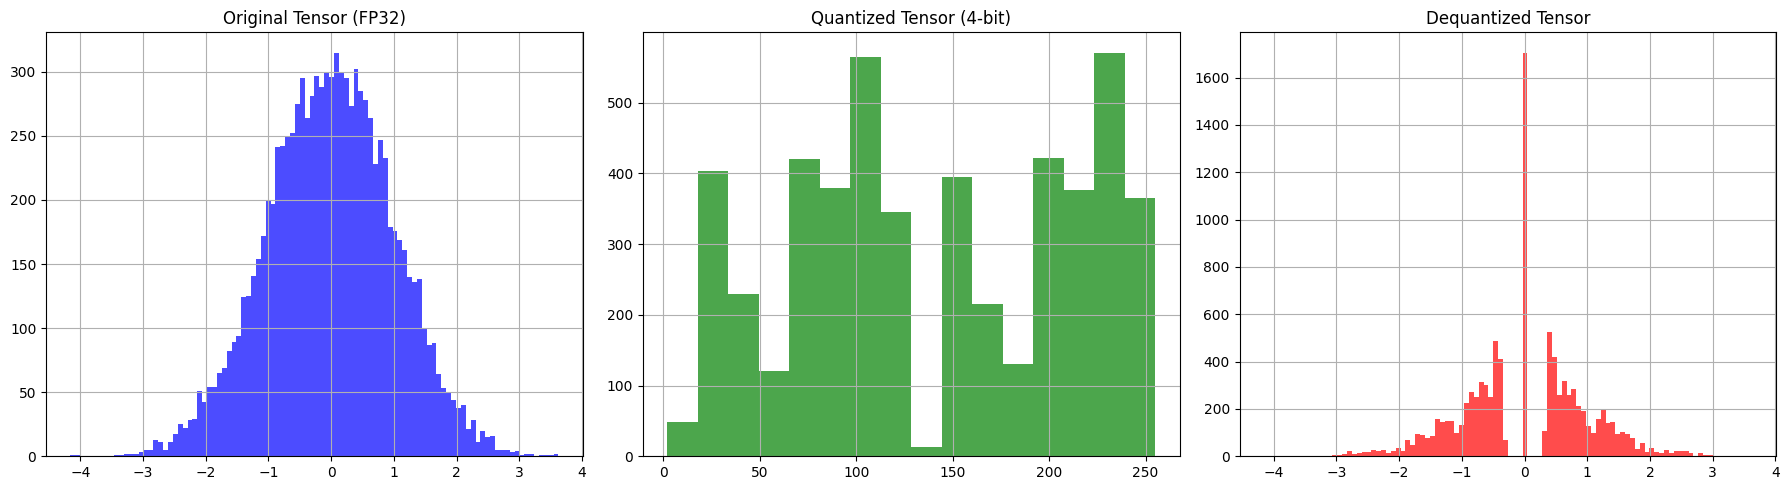

In [2]:
tensor_fp32 = torch.randn(100, 100, dtype=torch.float32).cuda()
print(f"Original: {tensor_fp32} \n")

quantized_tensor = bnb.functional.quantize_4bit(tensor_fp32)
print(f"Quantized: {quantized_tensor[0]} \n")

dequantized_tensor = bnb.functional.dequantize_4bit(quantized_tensor[0],quantized_tensor[1])
print(f"Dequantized: {dequantized_tensor} \n")

# Move everything to CPU for easier plotting
tensor_fp32_cpu = tensor_fp32.detach().cpu().flatten()
quantized_tensor_cpu = quantized_tensor[0].detach().cpu().flatten()
dequantized_tensor_cpu = dequantized_tensor.detach().cpu().flatten()

# Plot histograms
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(tensor_fp32_cpu.numpy(), bins=100, color='blue', alpha=0.7)
plt.title('Original Tensor (FP32)')
plt.grid(True)

plt.subplot(1,3,2)
plt.hist(quantized_tensor_cpu.numpy(), bins=16, color='green', alpha=0.7)
plt.title('Quantized Tensor (4-bit)')
plt.grid(True)

plt.subplot(1,3,3)
plt.hist(dequantized_tensor_cpu.numpy(), bins=100, color='red', alpha=0.7)
plt.title('Dequantized Tensor')
plt.grid(True)

plt.tight_layout()
plt.show()

# QLoRA

![QLORA](images/schema_QLORA.png)

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer,BitsAndBytesConfig, pipeline
import torch, gc

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

In [4]:
print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 0.08 MB |||||  Reserved:  70.00 MB:


In [5]:


DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_storage=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    device_map='cuda'
)
tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)

In [6]:
print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 1023.27 MB |||||  Reserved:  1574.00 MB:


In [16]:
model.model.layers[0].self_attn.q_proj.weight

Parameter containing:
Parameter(Params4bit([[-5.0852e+13],
            [ 1.2987e+22],
            [ 8.9369e+31],
            ...,
            [-1.3732e-26],
            [ 8.7257e+16],
            [-1.5272e-34]], device='cuda:0', dtype=torch.bfloat16))

In [7]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.self_attn.q_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.self_attn.k_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.self_attn.v_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.self_attn.o_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.mlp.gate_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.mlp.up_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.mlp.down_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.0.input_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.post_attention_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.1.self_attn.q_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.1.self_attn.k_proj.weight  dtype: torch.bfloat16  requirs grad:  False
model.layers.1.

In [6]:
from peft import LoraConfig, get_peft_model, PeftModel

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)


# Now manually move LoRA params to bf16
for name, param in model.named_parameters():
    if "lora_" in name:
        param.data = param.data.to(torch.bfloat16)
        if param.requires_grad:
            param.grad = None  # Reset grads just in case


model.print_trainable_parameters()

trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


In [7]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
ba

In [8]:
# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.

query = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}]


tokenized_query = tokenizer.apply_chat_template(query,tokenize=True,add_generation_prompt=True)

full_message = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"},
    {"role": "assistant", "content": "BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable."}
]


tokenized_full_message = tokenizer.apply_chat_template(full_message,tokenize=True,add_generation_prompt=False)

labels = tokenized_full_message
labels = [-100] * len(tokenized_query) + tokenized_full_message[len(tokenized_query):]

In [9]:
inputs = torch.tensor(tokenized_full_message).unsqueeze(0).to('cuda')
labels = torch.tensor(labels).to('cuda') 

In [10]:
print(tokenizer.decode([l for l in labels if l!=-100]))

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.<|eot_id|>


In [11]:
from torch.nn import functional as F
from torch.optim import AdamW
from tqdm import tqdm
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

model.config.use_cache = False
model.train()

print_gpu_utilization()
for _ in tqdm(range(5)):
    outputs = model(inputs)
    logits = outputs.logits[0]
    # Shift logits and labels for causal LM
    shift_logits = logits[:-1, :].contiguous()
    shift_labels = labels[1:].contiguous()
    loss = F.cross_entropy(
    shift_logits,
    shift_labels.view(-1),
)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    print("Loss:", loss.item())
    # flush()
    print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 1044.69 MB |||||  Reserved:  1548.00 MB:


 40%|████      | 2/5 [00:00<00:00,  3.82it/s]

Loss: 3.923828125
GPU Memory Usage>>>> Allocated: 1120.82 MB |||||  Reserved:  1618.00 MB:
Loss: 2.021484375
GPU Memory Usage>>>> Allocated: 1120.82 MB |||||  Reserved:  1666.00 MB:


 80%|████████  | 4/5 [00:00<00:00,  5.79it/s]

Loss: 0.94921875
GPU Memory Usage>>>> Allocated: 1120.82 MB |||||  Reserved:  1666.00 MB:
Loss: 0.251953125
GPU Memory Usage>>>> Allocated: 1120.82 MB |||||  Reserved:  1666.00 MB:


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]

Loss: 0.046875
GPU Memory Usage>>>> Allocated: 1120.82 MB |||||  Reserved:  1666.00 MB:


In [13]:
# Q: What is BG-CNN and what does it do?
# A: BG-CNN is a hybrid FDI method that combines Bond Graph residual generation with CNN-based fault classification, designed to work well even with limited labeled data.

# Q: How does BG-XAI help in fault diagnosis?
# A: BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.


model.eval()
model.config.use_cache = True


messages = [
    {"role": "user", "content": "How does BG-XAI help in fault diagnosis?"}
]

tokenized_text = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generated_text = llama_pipeline(tokenized_text, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'])

import gc
# flush()
print_gpu_utilization()


Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForC

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

How does BG-XAI help in fault diagnosis?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

BG-XAI provides explanations for fault predictions using an occlusion-based method, helping make AI-based diagnostics more understandable.
GPU Memory Usage>>>> Allocated: 1120.82 MB |||||  Reserved:  1666.00 MB:
